# IP Adapters
paper link: https://arxiv.org/pdf/2308.06721

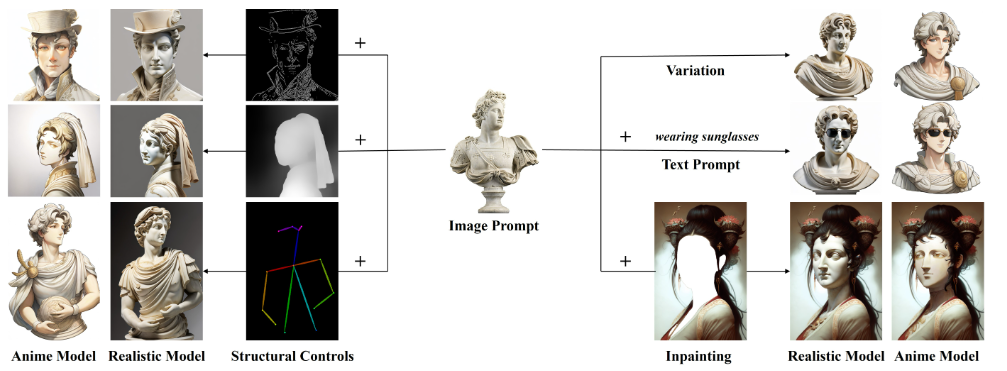


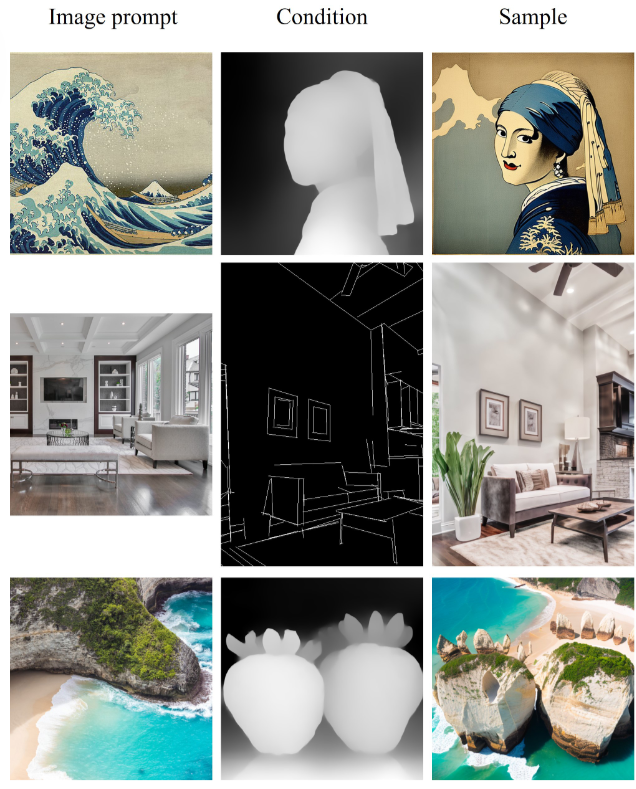


IP-Adapter is a lightweight module that enables pretrained text-to-image diffusion models to incorporate image prompts by adding a decoupled cross-attention mechanism that processes text and image features separately.


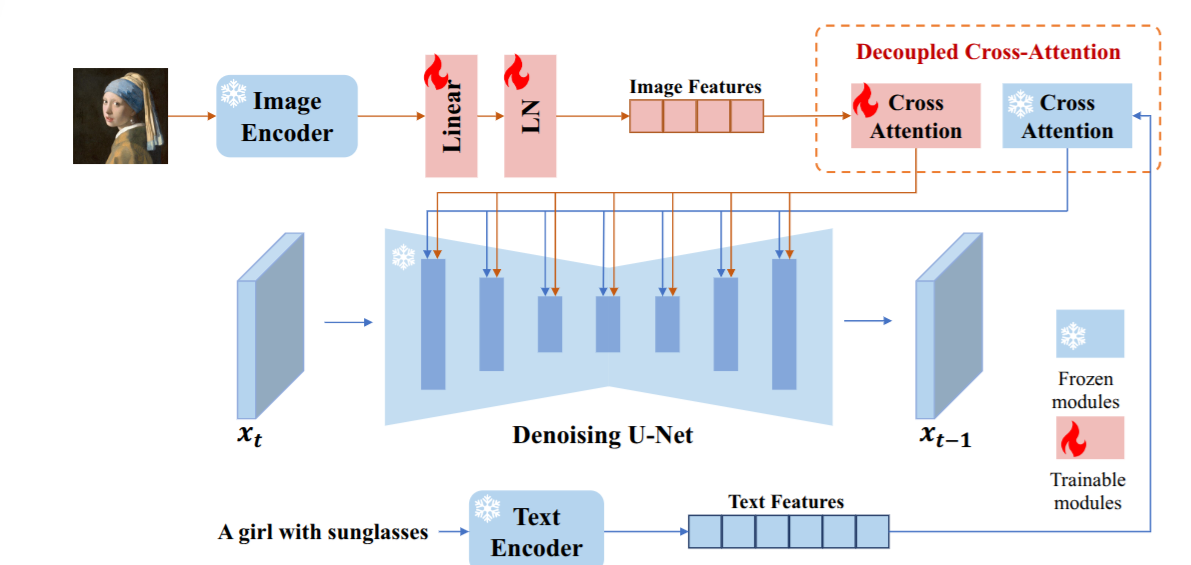

In [1]:
import numpy as np
import torch
from pathlib import Path
from diffusers.utils import load_image
from PIL import Image
from tqdm.auto import tqdm
from torchvision import transforms
import matplotlib.pyplot as plt
from IPython.display import clear_output
from diffusers import StableDiffusionPipeline,DPMSolverMultistepScheduler,DDIMScheduler

device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [2]:
model_id = 'stable-diffusion-v1-5/stable-diffusion-v1-5'

pipeline = StableDiffusionPipeline.from_pretrained(model_id, 
                                                   safety_checker=None, 
                                                   torch_dtype=torch.float16, 
                                                   device_map=device)
pipeline.scheduler = DDIMScheduler.from_config(pipeline.scheduler.config)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


# Load IP adapter

In [3]:
pipeline.load_ip_adapter(
  "h94/IP-Adapter",
  subfolder='models', 
  weight_name="ip-adapter-plus_sd15.bin"
)

# Generate Image Variations (prompt = '')

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

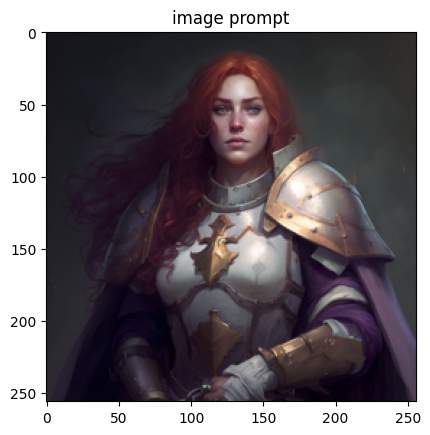

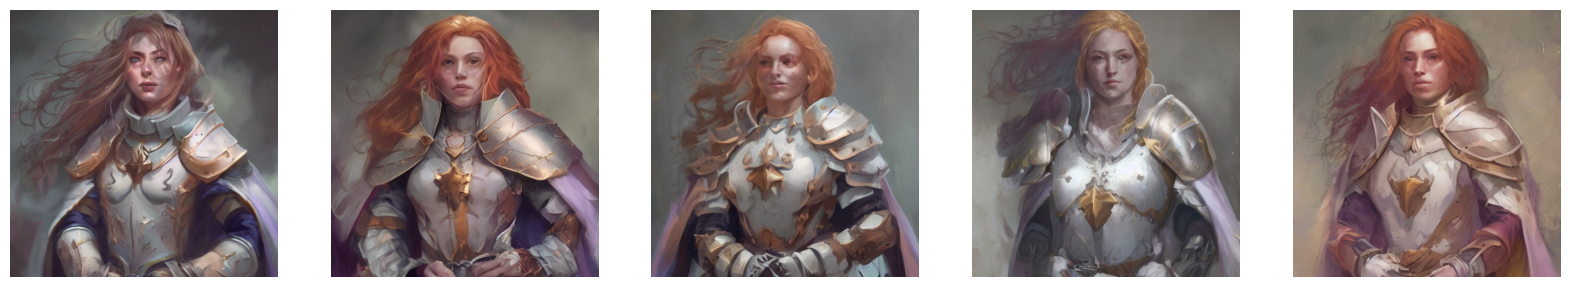

In [4]:
pipeline.set_ip_adapter_scale(1.0)
image = load_image("woman.png").resize((256,256))
gen_images=[]

for _ in range(5):
    gen_image =     pipeline(
            prompt="",
            ip_adapter_image=image,
            guidance_scale=1,
            num_inference_steps=50,
            height=512,
            width=512,
        ).images[0]

    gen_images.append(gen_image)
    
plt.imshow(image)
plt.title('image prompt')
plt.show()

fig,axes = plt.subplots(1,5,figsize=(20,20))
for i,ax in enumerate(axes):
    ax.imshow(gen_images[i])
    ax.axis('off')
plt.show()

# Apply different scale to the IP adapter

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

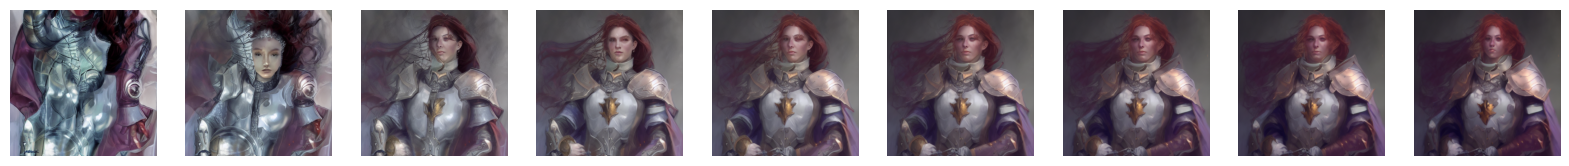

In [6]:

image = load_image("woman.png").resize((256,256))
gen_images=[]

for ip_scale in [0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6,1.8]:
    pipeline.set_ip_adapter_scale(ip_scale)
    gen_image =     pipeline(
            prompt="",
            guidance_scale=1,
            ip_adapter_image=image,
            num_inference_steps=50,
            height=512,
            width=512,
            generator=torch.manual_seed(0)
        ).images[0]

    gen_images.append(gen_image)

fig,axes = plt.subplots(1,9,figsize=(20,20))
for i,ax in enumerate(axes):
    ax.imshow(gen_images[i])
    ax.axis('off')
plt.show()

#  Image 2 image with IP-Adapter

In [10]:
from diffusers import StableDiffusionImg2ImgPipeline
im2im_pipeline = StableDiffusionImg2ImgPipeline.from_pipe(pipeline)

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_img2img.StableDiffusionImg2ImgPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


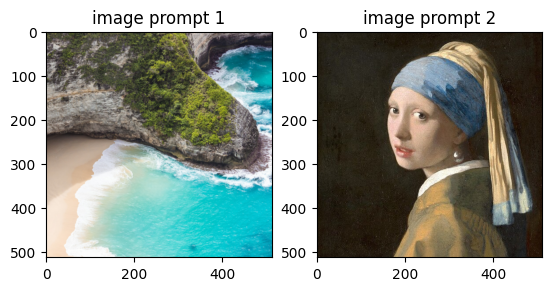

In [7]:
image = load_image("river.png")
g_image = load_image("vermeer.jpg")

plt.subplot(1,2,1)
plt.imshow(image)
plt.title('image prompt 1')
plt.subplot(1,2,2)
plt.imshow(g_image)
plt.title('image prompt 2')
plt.show()

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

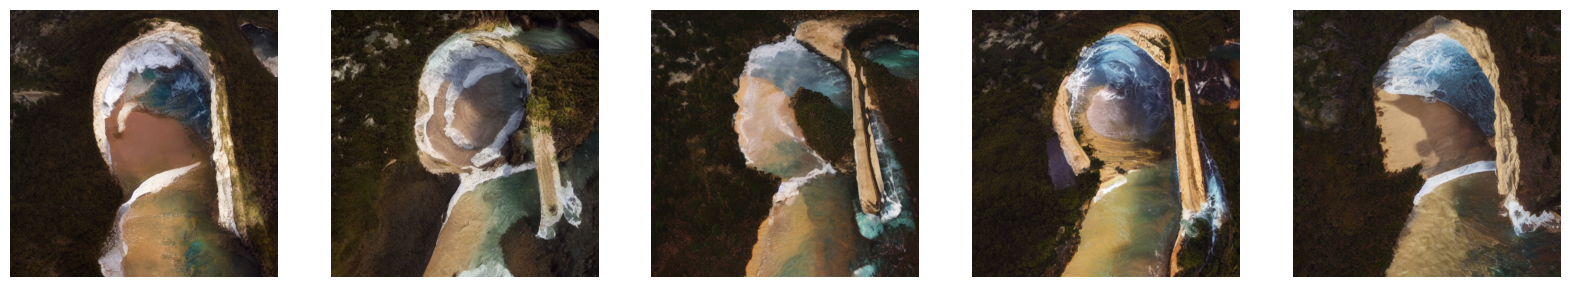

In [15]:
pipeline.set_ip_adapter_scale(1.0)
ip_adapter_images = image.resize((256,256))
gen_images=[]

for seed in range(5):
    gen_image = im2im_pipeline(
                                prompt="",
                                image = g_image,
                                strength=0.6,
                                ip_adapter_image=ip_adapter_images,
                                guidance_scale=1,
                                num_inference_steps=50,
                                height=512,
                                width=512,
                                generator=torch.manual_seed(seed)
                            ).images[0]

    gen_images.append(gen_image)
    


fig,axes = plt.subplots(1,5,figsize=(20,20))
for i,ax in enumerate(axes):
    ax.imshow(gen_images[i])
    ax.axis('off')
plt.show()

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

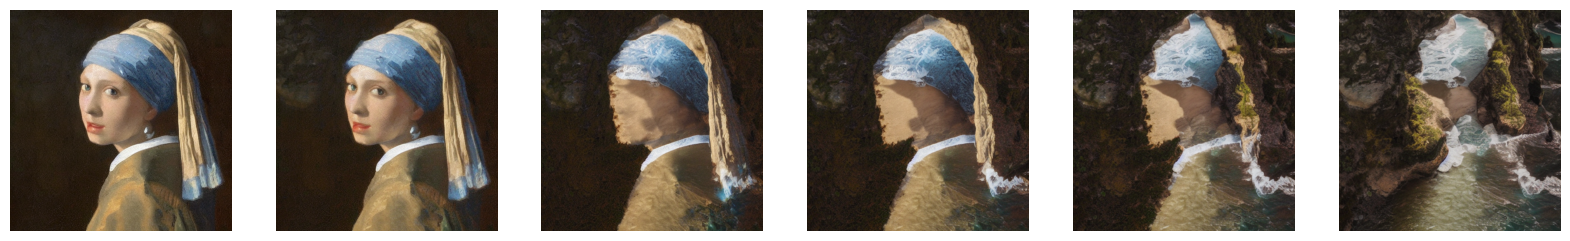

In [17]:
pipeline.set_ip_adapter_scale(1.0)
ip_adapter_images = image.resize((256,256))
gen_images=[]

for strength in [0.2,0.4,0.5,0.6,0.7,0.8]:
    gen_image = im2im_pipeline(
                                prompt="",
                                image = g_image,
                                strength=strength,
                                ip_adapter_image=ip_adapter_images,
                                guidance_scale=1,
                                num_inference_steps=50,
                                height=512,
                                width=512,
                                generator=torch.manual_seed(seed)
                            ).images[0]

    gen_images.append(gen_image)
    


fig,axes = plt.subplots(1,6,figsize=(20,10))
for i,ax in enumerate(axes):
    ax.imshow(gen_images[i])
    ax.axis('off')
plt.show()

# Inpianting with IP-Adapter

In [3]:
from diffusers import StableDiffusionInpaintPipeline
inpaint_pipeline = StableDiffusionInpaintPipeline.from_pipe(pipeline)

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_inpaint.StableDiffusionInpaintPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


In [4]:
inpaint_pipeline.load_ip_adapter(
  "h94/IP-Adapter",
  subfolder='models', 
  weight_name="ip-adapter-full-face_sd15.bin"
)

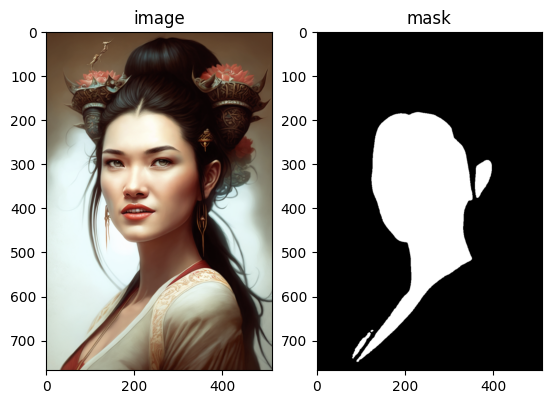

In [5]:
inpaint_image = load_image("inpainting/image.png").resize((512, 768))
inpaint_mask = load_image("inpainting/mask.png").resize((512, 768))

#plot these two
plt.subplot(1,2,1)
plt.imshow(inpaint_image)
plt.title('image')
plt.subplot(1,2,2)
plt.imshow(inpaint_mask)
plt.title('mask')
plt.show()


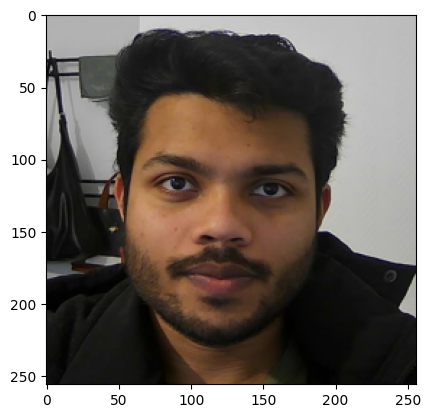

In [6]:
ip_image = load_image("mohan_face.jpg").resize((256,256))
plt.imshow(ip_image)
plt.show()

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

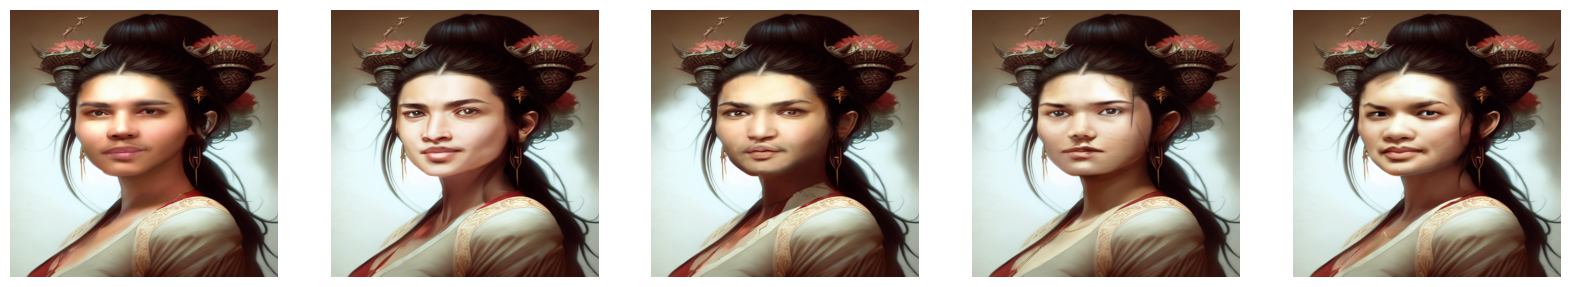

In [8]:
inpaint_pipeline.set_ip_adapter_scale(0.6)
gen_images=[]

for seed in range(5):
    gen_image = inpaint_pipeline(
                                prompt="",
                                image = inpaint_image,
                                mask_image = inpaint_mask,
                                strength=0.6,
                                ip_adapter_image=ip_image,
                                guidance_scale=1,
                                num_inference_steps=50,
                                height=512,
                                width=512,
                                generator=torch.manual_seed(seed)
                            ).images[0]

    gen_images.append(gen_image)
    


fig,axes = plt.subplots(1,5,figsize=(20,20))
for i,ax in enumerate(axes):
    ax.imshow(gen_images[i])
    ax.axis('off')
plt.show()